# Trade profile of a country

Trade profile of a country. Analysis of trade balances, main exports and imports, main trade partners and main competitors.

More info in [country_trade_profile_README_EN.md](country_trade_profile_README_EN.md)

## Setup

For instructions and how to obtain an API key, see [here](0-comtrade-setup-first.ipynb).

In [28]:
import logging
import sys

# Configure logging to output to stdout and set level to DEBUG or INFO
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# Example info message
logging.info("This is an info message")
# Example debug message
logging.debug("This is a debug message")

INFO:root:This is an info message
DEBUG:root:This is a debug message


In [29]:
import comtradetools as comtradetools

comtradetools.setup()
APIKEY = comtradetools.get_api_key()
comtradetools.init(APIKEY, force_init=False)


In [30]:
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

## Country and period of interest

Choose country and years of interest

In [31]:
import comtradetools


country_of_interest_name = 'USA'
country_of_interest = comtradetools.encode_country(country_of_interest_name)

years_of_interest=comtradetools.year_range(2001,2023)
print(country_of_interest_name, country_of_interest, years_of_interest)

USA 842 2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [32]:
from datetime import datetime

current_datetime = datetime.now()
print(f"Start run for {country_of_interest_name}:", current_datetime)

Start run for USA: 2025-04-20 08:29:51.213939


## 1.Trade balance

### 1a Trade balance symmetric values

In [33]:
import comtradetools
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

global_trade = comtradetools.get_trade_flows(country_of_interest,
                                        period=years_of_interest,
                                        period_size=1,  # how may years fetched in one call
                                        retry_if_empty=False,
                                        symmetric_values=True)

cols_of_interest = global_trade.columns



DEBUG:root:Function parameters: {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 842, 'partnerCode': 0, 'partner2Code': 0, 'flowCode': 'M', 'period': '2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023', 'period_size': 1, 'retry_if_empty': False, 'motCode': 0, 'customsCode': 'C00', 'cmdCode': 'TOTAL', 'clCode': 'HS', 'includeDesc': True}
INFO:root:Calling getFinalData for period 2001
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 842, 'partnerCode': 0, 'partner2Code': 0, 'flowCode': 'M', 'period': '2001', 'motCode': 0, 'customsCode': 'C00', 'cmdCode': 'TOTAL', 'clCode': 'HS', 'includeDesc': True}False
DEBUG:root:Getting data from cache for period 2001
INFO:root:Using cached results for period 2001
INFO:root:Calling getFinalData for period 2002
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 842, 'partnerCode': 0, 'partner2Code': 0, 'flowCode': 'M', 'period': '2002', 'motCode': 0, 'c

/workspaces/cipf-comtrade/comtradetools.py:664: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/workspaces/cipf-comtrade/comtradetools.py:664: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/workspaces/cipf-comtrade/comtradetools.py:664: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns 

DEBUG:root:Getting data from cache for period 2020
INFO:root:Using cached results for period 2020
INFO:root:Calling getFinalData for period 2021
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 842, 'partnerCode': 0, 'partner2Code': 0, 'flowCode': 'X', 'period': '2021', 'clCode': 'HS', 'cmdCode': 'TOTAL', 'customsCode': 'C00', 'motCode': 0, 'includeDesc': True}False
DEBUG:root:Getting data from cache for period 2021
INFO:root:Using cached results for period 2021
INFO:root:Calling getFinalData for period 2022
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 842, 'partnerCode': 0, 'partner2Code': 0, 'flowCode': 'X', 'period': '2022', 'clCode': 'HS', 'cmdCode': 'TOTAL', 'customsCode': 'C00', 'motCode': 0, 'includeDesc': True}False
DEBUG:root:Getting data from cache for period 2022
INFO:root:Using cached results for period 2022
INFO:root:Calling getFinalData for period 2023
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 842, 'partnerC

/workspaces/cipf-comtrade/comtradetools.py:664: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/workspaces/cipf-comtrade/comtradetools.py:664: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


INFO:root:Calling getFinalData for period 2012
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': None, 'partnerCode': 842, 'partner2Code': 0, 'flowCode': 'X', 'period': '2012', 'clCode': 'HS', 'customsCode': 'C00', 'cmdCode': 'TOTAL', 'motCode': 0, 'includeDesc': True}False
DEBUG:root:Getting data from cache for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': None, 'partnerCode': 842, 'partner2Code': 0, 'flowCode': 'X', 'period': '2013', 'clCode': 'HS', 'customsCode': 'C00', 'cmdCode': 'TOTAL', 'motCode': 0, 'includeDesc': True}False
DEBUG:root:Getting data from cache for period 2013
INFO:root:Using cached results for period 2013
INFO:root:Calling getFinalData for period 2014
DEBUG:root:Call {'typeCode': 'C', 'freqCode': 'A', 'reporterCode': None, 'partnerCode': 842, 'partner2Code': 0, 'flowCode': 'X', 'period': '2014', 'clCode': 'HS', 'customsCo

In [34]:
global_trade['varM_perc']=global_trade['M<X']/global_trade['M<X']
global_trade['varX_perc']=global_trade['X<M']/global_trade['X<M']
print(f"M = Imports as reported by {country_of_interest_name}")
print(f"X = Exports as reported by {country_of_interest_name}")
print(f"X<M = Exports as imports from {country_of_interest_name} reported by rest of the world")
print(f"M<X = Imports as exports to {country_of_interest_name} reported by rest of the world")
global_trade


M = Imports as reported by USA
X = Exports as reported by USA
X<M = Exports as imports from USA reported by rest of the world
M<X = Imports as exports to USA reported by rest of the world


flowCode,M,M<X,X,X<M,trade_balance (X-M),trade_balance (X<M-M),trade_balance (X<M-M<X),trade_volume (X+M),trade_volume (X<M+M),trade_volume (X<M+M<X),varM_perc,varX_perc
period,,,,,,,,,,,,
2001,"1,140,900,159,185.00","1,059,417,252,427.97","729,080,421,077.00","762,302,942,974.64","-411,819,738,108.00","-378,597,216,210.36","-297,114,309,453.33","1,869,980,580,262.00","1,903,203,102,159.64","1,821,720,195,402.61",1.00,1.00
2002,"1,200,095,833,882.00","1,095,234,320,146.67","693,068,306,701.00","732,484,087,595.86","-507,027,527,181.00","-467,611,746,286.14","-362,750,232,550.80","1,893,164,140,583.00","1,932,579,921,477.86","1,827,718,407,742.53",1.00,1.00
2003,"1,302,833,508,196.00","1,181,390,244,995.97","724,736,583,355.00","763,953,700,037.27","-578,096,924,841.00","-538,879,808,158.73","-417,436,544,958.70","2,027,570,091,551.00","2,066,787,208,233.27","1,945,343,945,033.24",1.00,1.00
2004,"1,525,304,217,271.00","1,372,775,484,993.05","814,844,394,245.00","857,389,771,390.52","-710,459,823,026.00","-667,914,445,880.48","-515,385,713,602.53","2,340,148,611,516.00","2,382,693,988,661.52","2,230,165,256,383.57",1.00,1.00
2005,"1,734,849,141,777.00","1,529,276,249,437.62","901,041,411,256.00","926,436,604,902.63","-833,807,730,521.00","-808,412,536,874.37","-602,839,644,534.99","2,635,890,553,033.00","2,661,285,746,679.63","2,455,712,854,340.25",1.00,1.00
2006,"1,918,997,094,449.00","1,736,660,721,050.72","1,037,029,245,257.00","1,047,964,113,842.38","-881,967,849,192.00","-871,032,980,606.62","-688,696,607,208.34","2,956,026,339,706.00","2,966,961,208,291.38","2,784,624,834,893.11",1.00,1.00
2007,"2,017,120,776,311.00","1,789,945,379,860.42","1,162,538,149,766.00","1,171,744,911,211.31","-854,582,626,545.00","-845,375,865,099.69","-618,200,468,649.11","3,179,658,926,077.00","3,188,865,687,522.31","2,961,690,291,071.73",1.00,1.00
2008,"2,164,834,031,060.00","1,916,782,996,523.26","1,299,898,877,213.00","1,325,524,602,718.11","-864,935,153,847.00","-839,309,428,341.89","-591,258,393,805.14","3,464,732,908,273.00","3,490,358,633,778.11","3,242,307,599,241.37",1.00,1.00
2009,"1,601,895,815,130.00","1,424,745,024,750.19","1,056,712,078,245.00","1,050,801,845,863.41","-545,183,736,885.00","-551,093,969,266.59","-373,943,178,886.79","2,658,607,893,375.00","2,652,697,660,993.41","2,475,546,870,613.60",1.00,1.00


Save to Excel file

In [35]:
start_year=global_trade.index.min()
end_year=global_trade.index.max()
excel_file = f"reports/{country_of_interest_name}_1.1_trade_balance_{start_year}-{end_year}.xlsx"
global_trade.to_excel(excel_file)
print("Trade balance report saved to ", excel_file)

Trade balance report saved to  reports/USA_1.1_trade_balance_2001-2023.xlsx


### Trade balance graph

Plot saved to  reports/USA_1.2_trade_balance_2001-2023.png
0 Line2D(M) 0.0
1 Line2D(M<X) 0.8
2 Line2D(X) 0.0
3 Line2D(X<M) 0.8
4 Line2D(trade_balance (X-M)) 0.0
5 Line2D(trade_balance (X<M-M)) 0.8
6 Line2D(trade_balance (X<M-M<X)) 0.0
7 Line2D(trade_volume (X+M)) 0.8
8 Line2D(trade_volume (X<M+M)) 0.0
9 Line2D(trade_volume (X<M+M<X)) 0.8


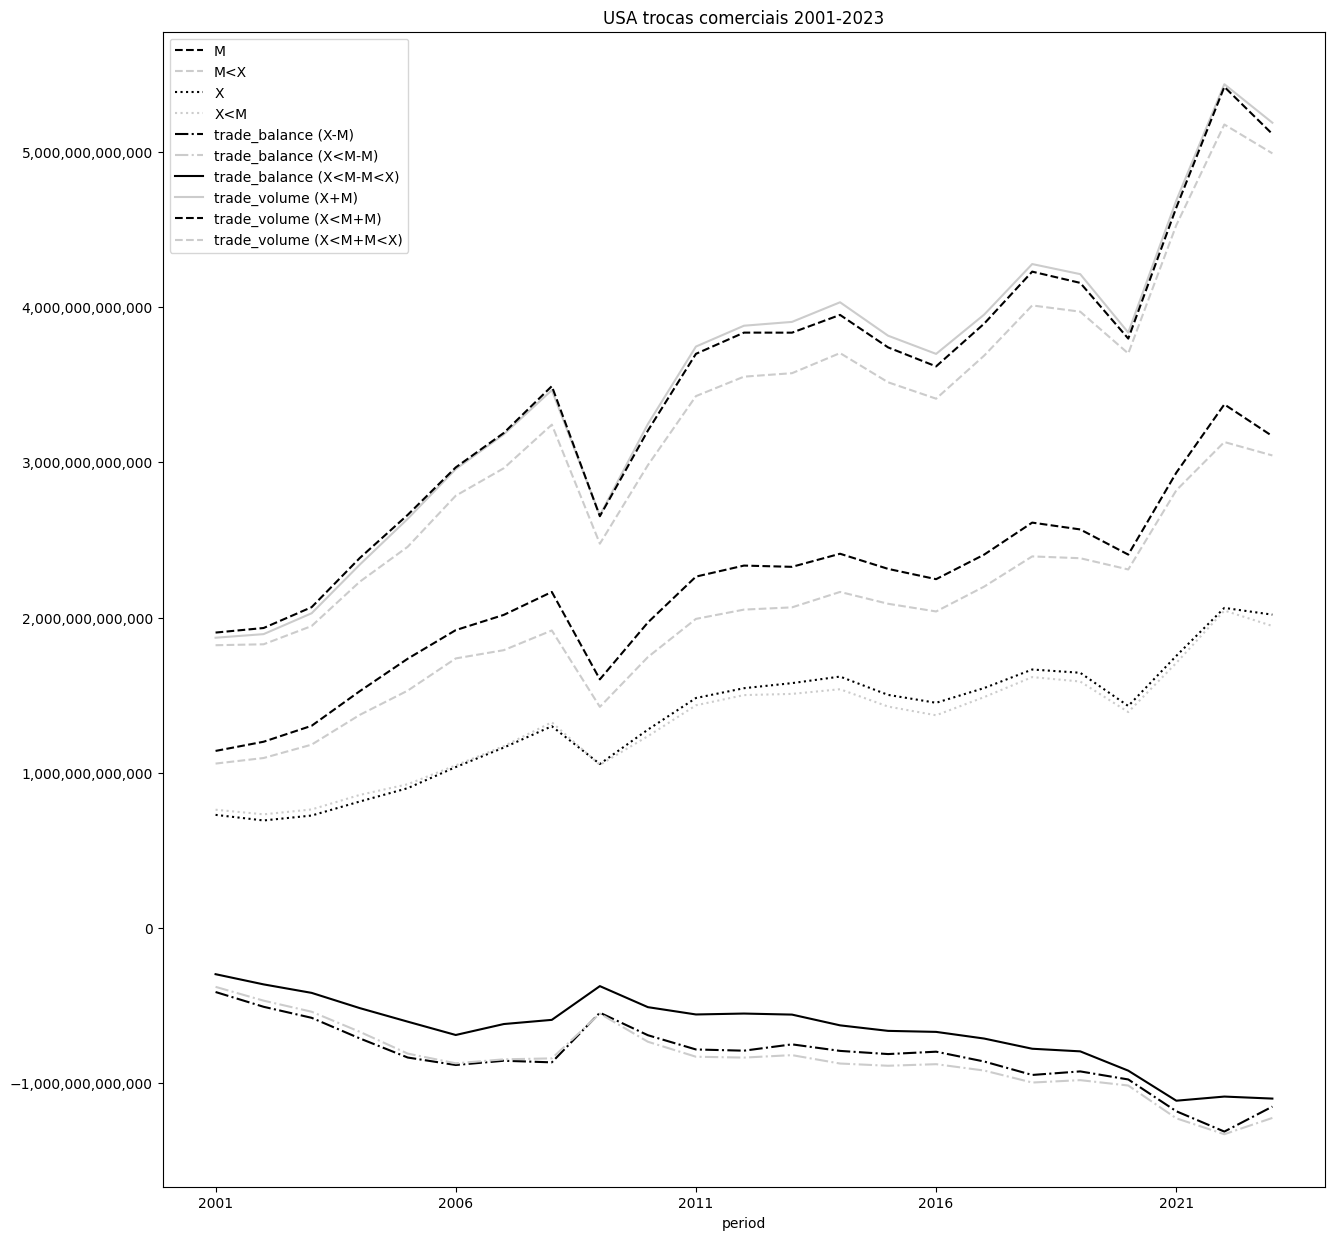

In [36]:
import logging

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
logging.basicConfig(level=logging.ERROR)

plotfile = f"reports/{country_of_interest_name}_1.2_trade_balance_{start_year}-{end_year}.png"

start_year=global_trade.index.min()
end_year=global_trade.index.max()
title=f"{country_of_interest_name} trocas comerciais {start_year}-{end_year}"
print("Plot saved to ", plotfile)
fig = global_trade[cols_of_interest].plot.line(figsize=(15,15),title=title)

# use a grayscale palette of colors
colors = ['0.0','0.8','0.0','0.8','0.0','0.8','0.0','0.8']

# use different line styles and black lines
linestyles = ['dashed', 'dashed', 'dotted', 'dotted', 'dashdot', 'dashdot', 'solid', 'solid']
for i, line in enumerate(fig.get_lines()):
    color = colors[i % len(colors)]
    print(i, line, color)
    line.set_color(color)
    line.set_linestyle(linestyles[i % len(linestyles)])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig.yaxis.set_major_formatter(formatter)
fig.legend(list(global_trade.columns.astype(str)))

plt.savefig(plotfile)
plt.show()

## 2. Exports


### 2.1 Main export partners/clients

Colect destinations of exports of the country. 

Use either reported exports
of country of interest, or reported imports from country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [37]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
    filename_symmetric_flag="reverse"
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'
    filename_symmetric_flag="direct"

In [38]:

df = comtradetools.getFinalData(APIKEY,
                                reporterCode=reporterCode,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode=flowCode,
                                period=years_of_interest,
                                period_size=1,
                                partnerCode=partnerCode,
                                remove_world=True,
                                partner2Code=0,  # world
                                clCode="HS",
                                cmdCode="TOTAL",
                                motCode=0,  # all means of transport
                                customsCode='C00', # all customs
                                includeDesc=True,
                                retry_if_empty=False,
                                cache=True
                                )

DEBUG:root:Function parameters: {'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023', 'period_size': 1, 'partnerCode': 842, 'remove_world': True, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'TOTAL', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True, 'retry_if_empty': False, 'cache': True}
INFO:root:Calling getFinalData for period 2001
DEBUG:root:Call {'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2001', 'partnerCode': 842, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'TOTAL', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Getting data from cache for period 2001
INFO:root:Using cached results for period 2001
INFO:root:Calling getFinalData for period 2002
DEBUG:root:Call {'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2002', 'partnerC

Compute percentage of trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [39]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5

# aggregate by year, flow, reporter
exports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode',f'{reporter_column}Desc','partner_rank',f'{partner_column}Desc','cmdCode','partner_sum','partner_perc','partner_upper_sum']

formats =  comtradetools.make_format(cols)

top_export_partners = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_export_partners_codes = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} export partners of {country_of_interest_name} in {years_of_interest}: \n{top_export_partners}")
exports[exports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).style.format(formats)

Top 5 export partners of USA in 2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['Canada' 'Germany' 'Japan' 'Mexico' 'United Kingdom' 'China']


,refYear,flowCode,partnerDesc,partner_rank,reporterDesc,cmdCode,partner_sum,partner_perc,partner_upper_sum
24,2001,M,USA,1,Canada,TOTAL,"$140,999,710,443",18.497%,"$762,302,942,975"
95,2001,M,USA,2,Mexico,TOTAL,"$114,059,681,973",14.963%,"$762,302,942,975"
74,2001,M,USA,3,Japan,TOTAL,"$63,756,681,975",8.364%,"$762,302,942,975"
158,2001,M,USA,4,United Kingdom,TOTAL,"$47,341,166,810",6.210%,"$762,302,942,975"
55,2001,M,USA,5,Germany,TOTAL,"$39,831,645,000",5.225%,"$762,302,942,975"
191,2002,M,USA,1,Canada,TOTAL,"$139,278,667,428",19.015%,"$732,484,087,596"
260,2002,M,USA,2,Mexico,TOTAL,"$106,899,862,231",14.594%,"$732,484,087,596"
239,2002,M,USA,3,Japan,TOTAL,"$58,808,959,340",8.029%,"$732,484,087,596"
323,2002,M,USA,4,United Kingdom,TOTAL,"$42,761,235,647",5.838%,"$732,484,087,596"
220,2002,M,USA,5,Germany,TOTAL,"$36,277,168,000",4.953%,"$732,484,087,596"


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [40]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna(0,inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)


Limit table to top_export_partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [41]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]
pivoted[show_only_columns].fillna(0)

partner_perc                                            \
reporterDesc           Canada China Germany Japan Mexico United Kingdom   
refYear flowDesc                                                          
2001    Import           0.18  0.03    0.05  0.08   0.15           0.06   
2002    Import           0.19  0.04    0.05  0.08   0.15           0.06   
2003    Import           0.19  0.04    0.06  0.08   0.14           0.06   
2004    Import           0.19  0.05    0.06  0.07   0.13           0.05   
2005    Import           0.19  0.05    0.06  0.07   0.13           0.05   
2006    Import           0.18  0.06    0.06  0.07   0.12           0.05   
2007    Import           0.18  0.06    0.05  0.06   0.12           0.05   
2008    Import           0.16  0.06    0.05  0.06   0.11           0.05   
2009    Import           0.16  0.07    0.05  0.06   0.11           0.05   
2010    Import           0.16  0.08    0.05  0.06   0.12           0.05   
2011    Import           0.16  0.09    0.05  0.05   0.12           0.04   
2012    Import           0.16  0.09    0.04  0.05   0.12           0.04   
2013    Import           0.16  0.10    0.04  0.05   0.12           0.04   
2014    Import           0.16  0.10    0.04  0.05   0.13           0.04   
2015    Import           0.16  0.10    0.05  0.05   0.13           0.04   
2016    Import           0.15  0.10    0.05  0.05   0.13           0.04   
2017    Import           0.15  0.10    0.05  0.05   0.13           0.04   
2018    Import           0.15  0.10    0.05  0.05   0.13           0.04   
2019    Import           0.14  0.08    0.05  0.05   0.13           0.04   
2020    Import           0.14  0.10    0.06  0.05   0.12           0.04   
2021    Import           0.14  0.11    0.05  0.05   0.13           0.03   
2022    Import           0.14  0.09    0.05  0.04   0.13           0.05   
2023    Import           0.14  0.08    0.05  0.04   0.13           0.05   

                       primaryValue                                        \
reporterDesc                 Canada              China            Germany   
refYear flowDesc                                                            
2001    Import   140,999,710,443.00  26,217,375,157.00  39,831,645,000.00   
2002    Import   139,278,667,428.00  27,261,096,545.00  36,277,168,000.00   
2003    Import   145,755,350,530.00  33,944,165,955.00  44,063,978,000.00   
2004    Import   160,827,006,670.00  44,747,868,764.00  50,013,340,000.00   
2005    Import   177,635,571,120.00  48,741,358,502.00  51,928,023,000.00   
2006    Import   192,177,944,211.00  59,314,269,712.00  61,792,385,000.00   
2007    Import   206,439,118,648.00  69,547,964,495.00  62,436,453,000.00   
2008    Import   214,046,444,022.00  81,585,556,125.00  69,639,042,575.11   
2009    Import   164,245,761,452.00  77,755,100,817.00  55,787,029,373.71   
2010    Import   197,547,488,641.00 102,734,184,535.00  61,153,544,468.63   
2011    Import   223,172,493,269.00 123,124,009,886.00  69,261,436,923.46   
2012    Import   234,075,807,499.00 133,765,823,048.00  67,205,165,280.86   
2013    Import   240,614,339,137.00 153,394,862,034.00  66,571,065,473.75   
2014    Import   251,814,355,795.00 160,064,513,783.00  67,526,624,079.61   
2015    Import   223,174,131,106.25 148,693,056,205.00  69,099,301,088.86   
2016    Import   209,921,524,454.78 135,120,133,073.00  65,963,435,127.41   
2017    Import   222,572,824,420.72 154,441,855,874.00  70,721,341,103.44   
2018    Import   235,121,903,895.43 156,015,756,423.00  78,295,030,921.82   
2019    Import   230,059,927,541.14 123,792,114,896.00  81,475,274,141.55   
2020    Import   197,970,690,292.68 136,339,520,982.00  78,402,821,566.85   
2021    Import   239,020,890,669.05 179,753,262,865.00  86,798,995,293.20   
2022    Import   281,474,445,210.65 178,956,829,551.00  99,761,080,104.04   
2023    Import   277,041,374,335.18 165,157,213,513.00 100,957,216,156.49   

                                                               

Make a table with the total value of exports for top partners in the period of interest

In [42]:
print("Top partners for exports: ",top_export_partners)
print("Period of interest:",years_of_interest)

Top partners for exports:  ['Canada' 'Germany' 'Japan' 'Mexico' 'United Kingdom' 'China']
Period of interest: 2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [43]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_export_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

reporterDesc,Canada,Mexico,China,Japan,Germany,United Kingdom
refYear,,,,,,
2001,"140,999,710,443.00","114,059,681,973.00","26,217,375,157.00","63,756,681,975.00","39,831,645,000.00","47,341,166,810.00"
2002,"139,278,667,428.00","106,899,862,231.00","27,261,096,545.00","58,808,959,340.00","36,277,168,000.00","42,761,235,647.00"
2003,"145,755,350,530.00","105,723,446,925.00","33,944,165,955.00","59,996,895,632.00","44,063,978,000.00","42,882,411,632.00"
2004,"160,827,006,670.00","111,262,254,142.00","44,747,868,764.00","63,702,093,123.00","50,013,340,000.00","45,420,373,482.00"
2005,"177,635,571,120.00","118,973,101,839.00","48,741,358,502.00","65,403,968,808.00","51,928,023,000.00","44,128,283,323.00"
2006,"192,177,944,211.00","130,809,817,420.00","59,314,269,712.00","69,384,707,246.00","61,792,385,000.00","53,490,012,163.00"
2007,"206,439,118,648.00","139,930,555,055.00","69,547,964,495.00","72,409,977,666.00","62,436,453,000.00","60,645,662,823.00"
2008,"214,046,444,022.00","151,746,429,617.00","81,585,556,125.00","78,937,218,521.00","69,639,042,575.11","63,856,136,866.00"
2009,"164,245,761,452.00","112,788,739,681.00","77,755,100,817.00","60,590,108,582.00","55,787,029,373.71","52,234,704,846.00"


Plot saved to  reports/USA_2.1.4_export_2001-2023_reverse.png
0 Line2D(_child0) #555555
1 Line2D(_child2) #666666
2 Line2D(_child4) #777777
3 Line2D(_child6) #888888
4 Line2D(_child8) #999999
5 Line2D(_child10) #AAAAAA


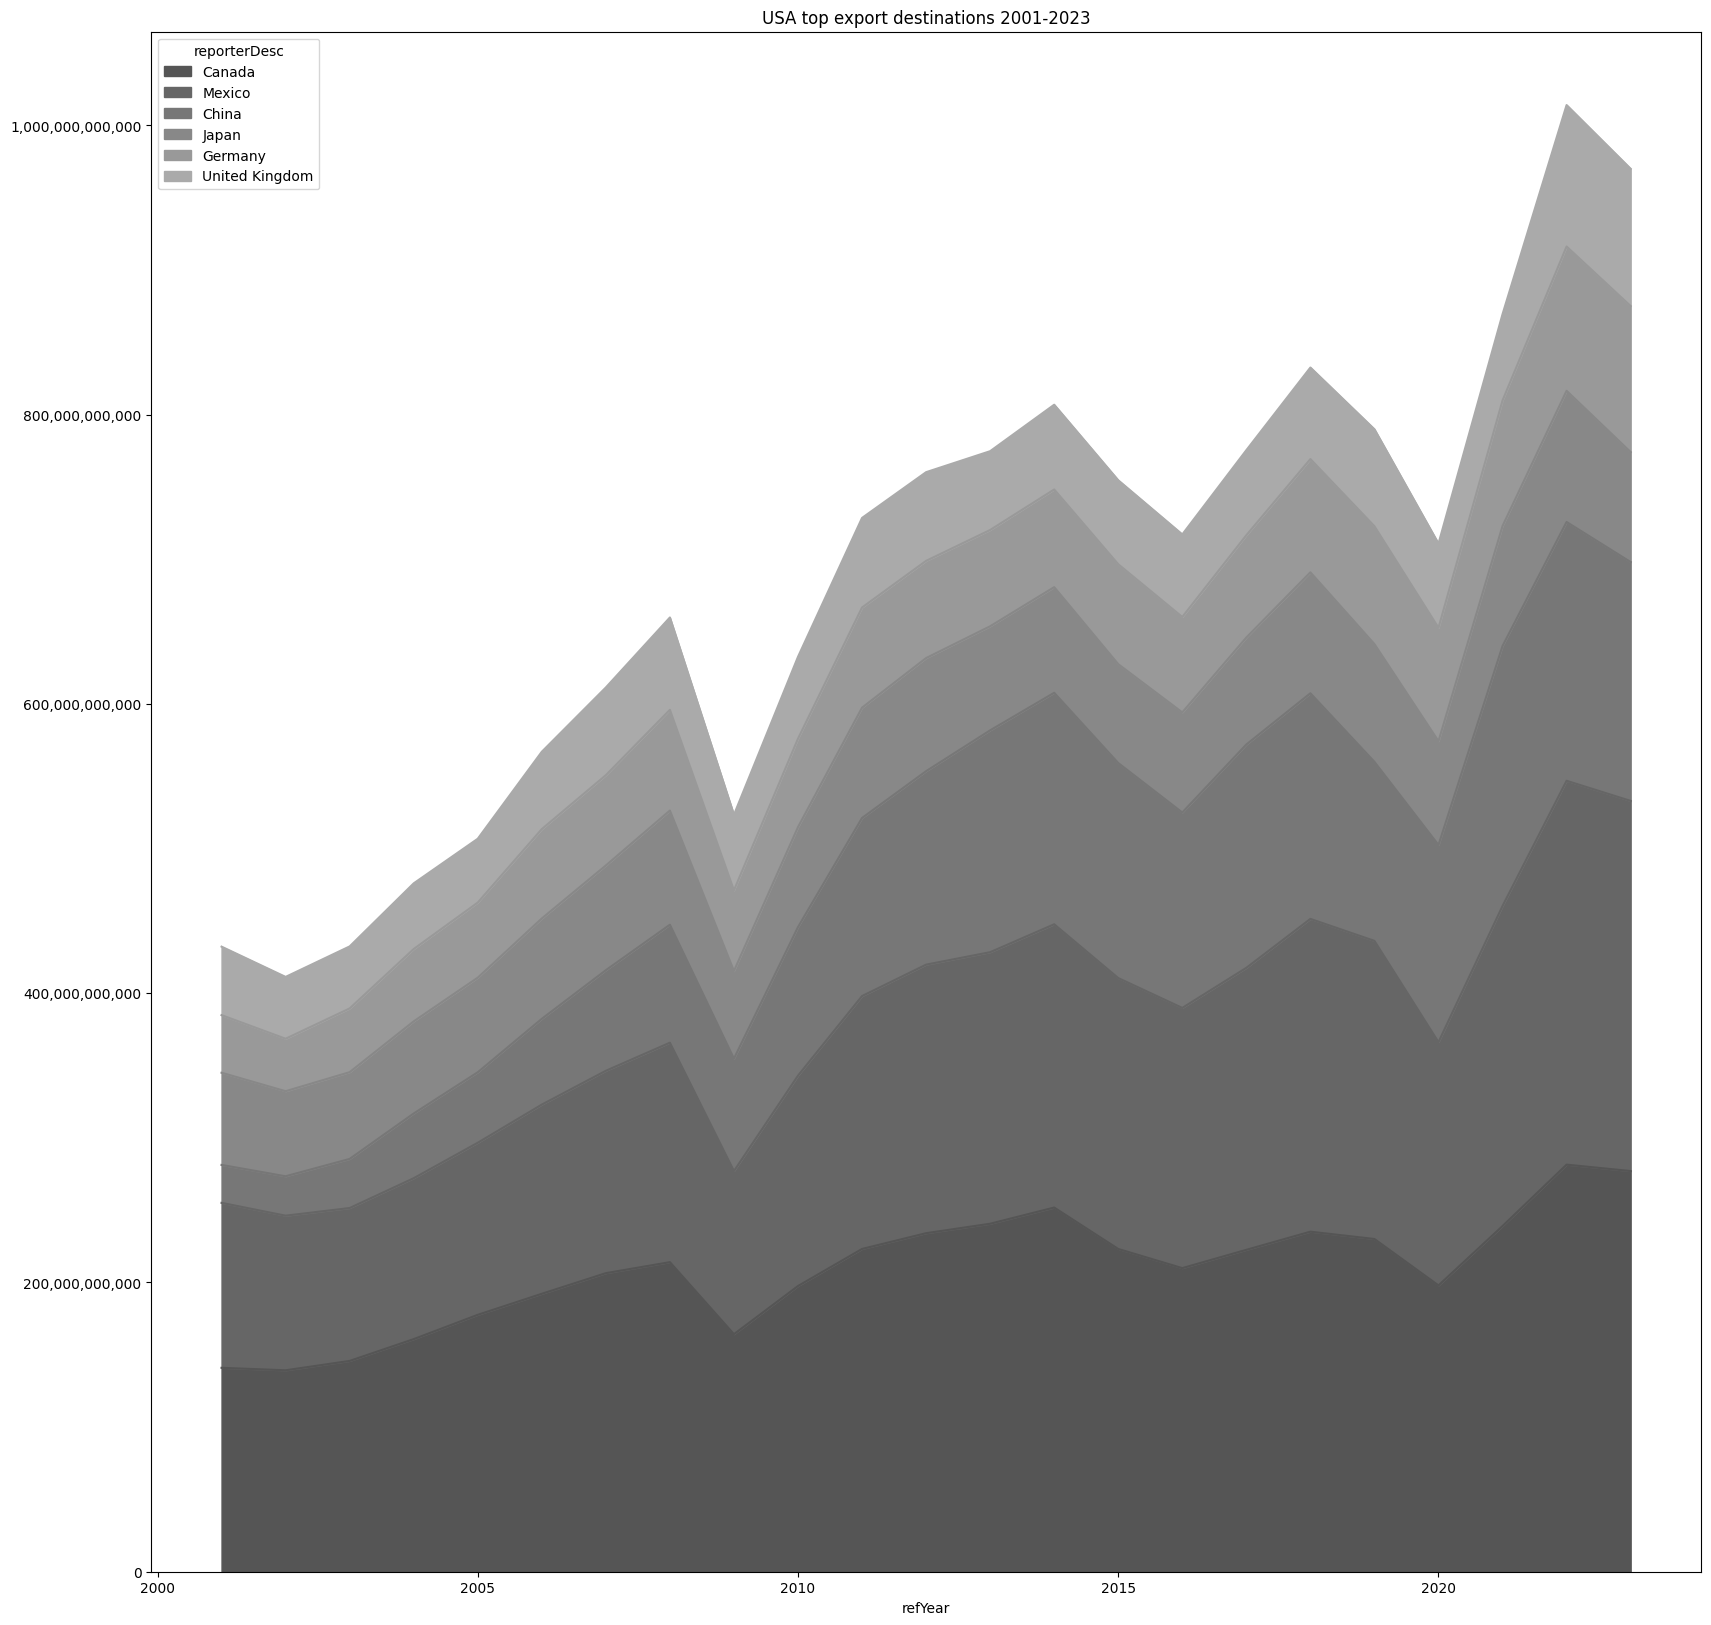

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plotfile = f"reports/{country_of_interest_name}_2.1.4_export_{start_year}-{end_year}_{filename_symmetric_flag}.png"
start_year=values_only.index.min()
end_year=values_only.index.max()
title=f"{country_of_interest_name} top export destinations {start_year}-{end_year}"
print("Plot saved to ", plotfile)
# see https://matplotlib.org/stable/gallery/color/named_colors.html
# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
colors = [ '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', ]

fig2 = values_only.plot.area(figsize=(20,20),title=title, color=colors)
for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

#### Export to Excel

Table with the top export destinations for the period of interest

In [45]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]

top_partners_file = f'reports/{country_of_interest_name}_2.1.1_top_export_partners_{filename_symmetric_flag}.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_2.1.2_top_export_partners_cols_{filename_symmetric_flag}.xlsx'
export_top_partners_file = f'reports/{country_of_interest_name}_2.1.3_export_top_{show_only_top}_partners_{start_year}-{end_year}_{filename_symmetric_flag}.xlsx'

exports[cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].to_excel(export_top_partners_file)

print(f"Top partners file: {top_partners_file}")
print(f"Top partners cols file: {top_partners_cols_file}")
print(f"Export top partners file: {export_top_partners_file}")

Top partners file: reports/USA_2.1.1_top_export_partners_reverse.xlsx
Top partners cols file: reports/USA_2.1.2_top_export_partners_cols_reverse.xlsx
Export top partners file: reports/USA_2.1.3_export_top_5_partners_2001-2023_reverse.xlsx


### 2.2 Exports: products

#### What are the main exported products

In [46]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5

print(country_of_interest_name, years_of_interest)

USA 2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


Get the products exported by country of interest

In [ ]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # use mode from previous cells

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
    filename_symmetric_flag="reverse"
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'
    filename_symmetric_flag="direct"

filename_symmetric_flag

'reverse'

: 

In [ ]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World Bank uses AG6
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True

                        )

DEBUG:root:Function parameters: {'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023', 'period_size': 1, 'partnerCode': 842, 'remove_world': False, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True, 'retry_if_empty': False, 'cache': True}
INFO:root:Calling getFinalData for period 2001
DEBUG:root:Call {'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2001', 'partnerCode': 842, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Getting data from cache for period 2001
INFO:root:Using cached results for period 2001
INFO:root:Calling getFinalData for period 2002
DEBUG:root:Call {'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2002', 'partnerCode

In [ ]:
print("Years available in the data:", df.refYear.unique())

In [ ]:
df.head()

Agreggate by product, keep the top products exported each year

In [ ]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
exports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
exports = exports[exports['product_rank']<=show_only_top]
exports.info()

cols=['refYear','flowCode','product_rank','cmdCode', 'cmdDesc','product_sum','product_upper_perc', 'product_upper_sum']
formats =  comtradetools.make_format(cols)

top_export_products_codes = exports['cmdCode'].unique()

print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
exports[cols].sort_values(['refYear','flowCode','product_rank']).head(10).style.format(formats)


#### Export to Excel

In [ ]:
filename = f'reports/{country_of_interest_name}_2.2_exports_{clCode}-{cmdDetail}-{exports["refYear"].min()}-{exports["refYear"].max()}_{filename_symmetric_flag}.xlsx'
print("Exporting to ",filename)
exports[cols].sort_values(['refYear','flowCode','product_rank']).to_excel(filename,index=False)

### 2.3 Export partners / products analysis

Which are the partners buying the top exports of country of interest?


In [ ]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # we keep the previous choice

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
    filename_symmetric_flag="reverse"
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'
    filename_symmetric_flag="direct"

filename_symmetric_flag

#### Caveat

Simmetrical reporting can vary greatly from direct reporting.

Example:

Mozambique exports to Netherlands in 2008

#### Analyse assymetric reporting (optional)

Choose pair of countries and a year to compare exports with partner imports

Example: Mozambique exports to Netherlands in 2008 and Netherlands imports from Mozambique in 2008

Netherlands does not reports a 1,451,846,140.00	USD export of Aluminium and articles thereof that Mozambique declares.

Note that World Bank used Mozambique export data as reported by Mozambique:

https://wits.worldbank.org/CountryProfile/en/Country/MOZ/Year/2008/Summarytext

In [ ]:
import comtradetools

analyse_symmetric = False  # if true a symmetry analysis is done, see the variables bellow

reporterA = country_of_interest
partner = None
year_of_reference = "2023"



##### Compare declared exports with declared imports of partner

In [ ]:
import comtradetools
import pandas as pd

partnerA = comtradetools.encode_country(partner)

if analyse_symmetric:
    clCode = 'HS'
    cmdDetail = 'AG2'  # not all countries report at higher detail

    cols = ['refYear','reporterDesc', 'flowCode','partnerDesc','cmdCode','cmdDesc','primaryValue']
    declared_exports = comtradetools.getFinalData(   # exports as declare by reporter
                            APIKEY,
                            reporterCode=reporterA,
                            typeCode='C',  # commodities
                            freqCode='A',  # annual
                            flowCode='X',
                            period=year_of_reference,
                            partnerCode=partnerA,
                            remove_world=True,
                            partner2Code=0,
                            clCode=clCode,
                            cmdCode=cmdDetail,
                            motCode=0,  # all means of transport
                            customsCode='C00',
                            includeDesc=True,
                            cache=True
                            )

    if declared_exports is None or declared_exports.empty:
        print("The DataFrame is either None or empty.")
    else:
        declared_exports = declared_exports[cols].sort_values('cmdCode')
    partner_imports = comtradetools.getFinalData(   # exports as declared by partner as imports
                        APIKEY,
                        reporterCode=partnerA,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode='M',
                        period=year_of_reference,
                        partnerCode=reporterA,
                        remove_world=True,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True)
    if partner_imports is None or partner_imports.empty:
        print("The DataFrame is either None or empty.")
    else:
        partner_imports = partner_imports[cols].sort_values('cmdCode')

    if (declared_exports is None or declared_exports.empty) or (partner_imports is None or partner_imports.empty):
        compared_data = 'Symmetry analysis not done, no symmetric data available'
    else:
        compared_data = pd.merge(declared_exports[cols], partner_imports[cols],
                                    left_on=['refYear','partnerDesc', 'cmdCode'],
                                    right_on=['refYear','reporterDesc', 'cmdCode'],
                                    how='outer').fillna(0, inplace=False)
        filename = f"reports/{country_of_interest_name}_2.1.5_export_import_symmetry_{partner}_{year_of_reference}.xlsx"
        compared_data.to_excel(filename, index=False)
        print("Symmetry analysis exported to ",filename)
else:
    compared_data = 'Symmetry analysis not done'

compared_data

Analyse partners

In [ ]:
import warnings
warnings.filterwarnings('default')

clCode = 'HS'
cmdDetail = 'AG6'  # not all countries report at higher detail

df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=True,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )

In [ ]:
cols=['refYear','flowCode','reporterDesc','partnerDesc','primaryValue','cmdCode','cmdDesc']
df[cols].sample(10)

In [ ]:
df.refYear.unique()

Aggregate by partner and keep the main ones

In [ ]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)

cols=['refYear',f'{reporter_column}Desc','flowCode','cmdCode','cmdDesc',f'{partner_column}Desc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats=comtradetools.make_format(cols)
products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_export_products_codes)
                       & (products_and_partners[f'{prefix}_rank']<=show_only_top))]


#### Show partners for main export products

In [ ]:
show_only = 30
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                             ascending=[True,True,False,True])\
                                             .head(show_only).style.format(formats) #.hide(axis='index')

#### Export to Excel

In [ ]:
filename = f'reports/{country_of_interest_name}_2.3_exports_products_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}_{filename_symmetric_flag}.xlsx'
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                             ascending=[True,True,False,True]).to_excel(filename, index=False)
print("Exporting to ",filename)

### 2.4 Main clients and products exported 

Detail of the main products by export partner.

Allows to analyse the mix of products of the main export partners from this country

In [ ]:
top_export_partners

In [ ]:
import comtradetools

show_only_top = 10

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='partner_cmd'
partners_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear',f'{reporter_column}Desc','flowCode',f'{partner_column}Desc','cmdCode','cmdDesc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats = comtradetools.make_format(cols)
partners_and_products=partners_and_products[(partners_and_products[f'{partner_column}Desc'].isin(top_export_partners)
                       & (partners_and_products[f'{prefix}_rank']<=show_only_top))]

print("First rows")
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Last rows

In [ ]:
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

In [ ]:
filename = f'reports/{country_of_interest_name}_2.4_exports_partners_products_{clCode}-{cmdDetail}-{partners_and_products["refYear"].min()}-{partners_and_products["refYear"].max()}_{filename_symmetric_flag}.xlsx'
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False])[cols].to_excel(filename, index=False)
print("Exporting to ",filename)

### 2.5 Alternative suppliers of costumers of country of interest




For each year, partner, exported commodity, fetches all the imports of
the commodity by partner from other countries, and computes the ranking
of country of interest among the suppliers of partner for that commodity,
e.g.

Country of interest：Angola, in 2021, China, exported commodity code 270900 "Oils; petroleum oils and oils obtained 
from bituminous minerals, crude" ; fetch all suppliers of 270900 of China and compute
the ranking of Angola.


First step is to get the combos of partner and commodity

In [ ]:
combos_of_interest = partners_and_products[(partners_and_products['cmdCode'].isin(top_export_products_codes)
                & (partners_and_products[f'{partner_column}Code'].isin(top_export_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

In [ ]:
# create lists of commodities codes and country codes to query comtrade
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

Get all the suppliers of client for products exported by contry of interest.

In [ ]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='M',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=1,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                cache=True,

                                )

Alternative, concatenating

In [ ]:
import pandas as pd

try_alternative = False

if try_alternative:
    df2: pd.DataFrame = None
    for countryCode,cmdCode in combos_of_interest:
        print(countryCode,cmdCode)
        tmp = comtradetools.getFinalData(APIKEY,
                                        reporterCode=countryCode,
                                        typeCode='C',  # commodities
                                        freqCode='A',  # annual
                                        flowCode='M',
                                        partnerCode=None,
                                        remove_world=True,
                                        partner2Code=0,
                                        period=years_of_interest,
                                        period_size=1,
                                        clCode='HS',
                                        cmdCode=cmdCode,  # Top level product types
                                        customsCode='C00',
                                        motCode=0,  # all means of transport
                                        )
        if df2 is None:
            df2 = tmp
        else:
            df2 = pd.concat([df2,tmp],axis=0)


Partners buying top products of country of interest.

In [ ]:
list(df.reporterDesc.unique()), list(df.partnerDesc.unique())


For each partner show the top supliers of the products bought from country of interest. 

If country of interest is not in the top five, show position anyway if it is a supplier in the given year 

In [ ]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_suppliers = comtradetools.total_rank_perc(
                                        df,
                                        groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                        col='primaryValue',
                                        prefix='cmd_partner',
                                        )

other_suppliers = other_suppliers[other_suppliers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','flowCode','refYear','cmdCode','cmdDesc','cmd_partner_rank','partnerDesc','primaryValue','cmd_partner_perc','cmd_partner_upper_sum']
formats =  comtradetools.make_format(cols)

other_suppliers[(other_suppliers['partnerCode'] == country_of_interest)
                | (other_suppliers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

### Ranking of country of interest in the supliers of main export products

Allows assessment of the importance of country of interest for the partners
that are buying its main exports.

In [ ]:
ignore_if_rank_is_higher = 25

relevant_for_partner_imports=other_suppliers[
    (other_suppliers['partnerCode'
                     ] == country_of_interest) &
    (other_suppliers['cmd_partner_rank'] < ignore_if_rank_is_higher)

                     ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank'])
relevant_for_partner_imports.head(50).style.format(formats).hide(axis='index')

In [ ]:
filename = f'reports/{country_of_interest_name}_2.5.1_export_partners_alternative_{filename_symmetric_flag}.xlsx'
print("Exporting to ",filename)
other_suppliers[cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).to_excel(filename)

In [ ]:
filename = f'reports/{country_of_interest_name}_2.5.2_export_partners_alternative_relevant_{filename_symmetric_flag}.xlsx'
print("Exporting to ",filename)
relevant_for_partner_imports.to_excel(filename)

## 3. Imports

In [ ]:
print(country_of_interest_name, years_of_interest)

### 3.1 Main import partners

Collect imports to country of interest.

Use either reported imports by country of interest, 
or reported exports to country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [ ]:
# If symmetric_reporting is "True" we get the imports from
#    the reported exports of all the countries
# i.e. instead of asking Country of Interest for import data we ask the world
#    for export data towards Country of Interest

symmetric_reporting = True  # set to false to use reported imports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [ ]:
clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6, but some codes AG4
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,  # imports
                        partnerCode=partnerCode, # every body
                        remove_world=True,
                        partner2Code=0, # ignore parter2
                        period=years_of_interest,
                        period_size=1,
                        clCode="HS",
                        cmdCode="TOTAL",
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )

Compute percentage of trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [ ]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5

# aggregate by year, flow, reporter
imports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode',f'{reporter_column}Desc','partner_rank',f'{partner_column}Desc','partner_sum','partner_perc','partner_upper_perc']

formats =  comtradetools.make_format(cols)

top_import_partners = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_import_partners_codes = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} import partners of {country_of_interest_name} in {years_of_interest}: \n{top_import_partners}")
imports[imports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank']).style.format(formats)

Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [ ]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna(0,inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0, inplace=True)
pivoted

Limit table to top import partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [ ]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]
pivoted[show_only_columns]

Make a table with the total value of import from top partners in the period of interest

In [ ]:
print("Top partners for import: ",top_import_partners)
print("Period of interest:",years_of_interest)

In [ ]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_import_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

In [ ]:
import matplotlib.pyplot as plt

title=f"{country_of_interest_name} top import origins {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_name}_3.1.4_import_partners_{start_year}-{end_year}.png"

# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
colors = [ '#333333','#444444', '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', '#DDDDDD', '#EEEEEE']
fig2 = values_only.plot.area(figsize=(20,20),title=title, color=colors)

for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    # print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

In [ ]:
plotfile

In [ ]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]
list(show_only_columns)

#### Export to Excel

Table with the top import origins for the period of interest

In [ ]:
top_partners_file = f'reports/{country_of_interest_name}_3.1.1_top_import_partners.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_3.1.2_top_import_partners_cols.xlsx'
import_top_partners_file = f'reports/{country_of_interest_name}_3.1.3_import_top_{show_only_top}_partners_{start_year}-{end_year}.xlsx'

imports[cols].sort_values(['refYear','flowCode','partner_rank']).to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].reset_index().to_excel(import_top_partners_file)

print(f"Top import partners file: {top_partners_file}")
print(f"Top import partners cols file: {top_partners_cols_file}")
print(f"Import top partners file: {import_top_partners_file}")

### 3.2 Imports: products

#### Main imported products

In [ ]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)

print(country_of_interest_name, years_of_interest)


Get the products imported by country of interest

In [ ]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # keep previous choice for consistency
if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

symmetric_reporting

In [ ]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6 Equatorial Guinea uses AG4
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )
df.info()

In [ ]:
print("Years available in the data:", list(df.refYear.unique()))

In [ ]:
cols=['refYear','flowCode','cmdCode', 'cmdDesc','classificationCode','aggrLevel','isLeaf']

df[cols].head()

Agreggate by product, keep the top products imported each year

In [ ]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
imports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
imports = imports[imports['product_rank']<=show_only_top]
imports.info()

cols=['refYear','flowCode','product_rank','cmdCode', 'cmdDesc','product_sum','product_upper_perc','classificationCode','aggrLevel','isLeaf', 'product_upper_sum']
formats =  comtradetools.make_format(cols)

top_import_products_codes = imports['cmdCode'].unique()

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
imports[cols].sort_values(['refYear','flowCode','product_rank']).head(10).style.format(formats)


### Caveat

For Angola results match https://trendeconomy.com/data/h2/Angola/TOTAL for AG2 and AG4 but not https://www.statista.com/statistics/1143152/value-of-imports-into-angola-by-category/  and close but not same as https://globaledge.msu.edu/countries/angola/tradestats

The imports match World Bank Wits data mostly, but in some years 
there seems to be a mismatch of HS Codes, with different descriptions in Wits
and values that sometimes match AG4 and not AG6 (2015,total is AG4:2710 not AG6:271012 )
and in same cases match the first 5 digits (2015: 73042 "Casings tubing...", 2021 10011, Durum Wheat)

Use the following cell to compute totals for codes with first 5 digit in common to compare with other sources

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:,.2f}'.format

code_prefix = '10011'
cols2=['refYear','flowCode','product_rank','cmdCode','cmdDesc','primaryValue','product_perc']

# select rows and columns
selected_rows = df[(df['refYear']==2021) & (df['cmdCode'].str.startswith(code_prefix))][cols2].sort_values(by=['primaryValue'],ascending=False).head(50)

# add total of primaryValue column
total = selected_rows['primaryValue'].sum()
selected_rows.loc['total'] = pd.Series({'primaryValue': total})

# display selected rows
selected_rows


In [ ]:
print("Years available in the data:", imports.refYear.unique())

#### Export to Excel

In [ ]:
filename = f'reports/{country_of_interest_name}_3.2_imports_products_{clCode}-{cmdDetail}-{imports["refYear"].min()}-{imports["refYear"].max()}.xlsx'
print("Exporting to ",filename)
imports[cols].sort_values(['refYear','flowCode','product_rank']).to_excel(filename,index=False)

### 3.3 Import partners / product analysis

Which are the partners selling the top imports by country of interest

In [ ]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # keep previous choice

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

In [ ]:
import warnings
warnings.filterwarnings('default')

clCode = 'HS'
cmdDetail = 'AG6'  # not all countries report at higher detail

df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1, # lots of data, better segment
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )
df.info()

In [ ]:
cols2=['refYear','flowCode','reporterDesc','partnerDesc','primaryValue','cmdCode','cmdDesc']
df[cols2].sample(10)

In [ ]:
df.refYear.unique()

Aggregate by partner and keep the main ones

In [ ]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5   # change to have more top partners

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top import partners ({len(top_import_partners)}): {top_import_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)
cols=['refYear','flowCode','cmdDesc','cmdCode',f'{partner_column}Desc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats=comtradetools.make_format(cols)

products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_import_products_codes)
                        & (products_and_partners[f'{prefix}_rank']<=show_only_top))]
print(f"Data available for years {products_and_partners.refYear.unique()}")


### Partners for main import products

In [ ]:
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                        ascending=[True,True,False,True])\
                                            .head(30).style.format(formats) #.hide(axis='index')

In [ ]:
filename = f'reports/{country_of_interest_name}_3.3_imports_products_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'
print("Exporting to ",filename)
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                        ascending=[True,True,False,True]).to_excel(filename, index=False)

### 3.4 Main partners and main products imported by country of interest

Detail of the main products by import partner.

Allows to analyse the mix of products of the main suppliers from this country.



In [ ]:
top_import_partners

In [ ]:
import comtradetools

show_only_top = 5  # for suppliers with wide range of products e.g PT->AO increase

print(f"Top import partners ({len(top_import_partners)}): {top_import_partners}")
prefix='partner_cmd'
suppliers_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear','flowCode',f'{partner_column}Desc',f'{prefix}_rank','cmdCode','cmdDesc',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats = comtradetools.make_format(cols)
suppliers_and_products=suppliers_and_products[(suppliers_and_products[f'{partner_column}Desc'].isin(top_import_partners)
                       & (suppliers_and_products[f'{prefix}_rank']<=show_only_top))]

print("First rows")
suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Last rows

In [ ]:

suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

#### Export to Excel

In [ ]:
filename = f'reports/{country_of_interest_name}_3.4_imports_partners_products_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'

suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).to_excel(filename, index=False)

print("Exporting to ",filename)

### 3.5 Get the alternative clients for country of interest suppliers

For each year, supplier, imported commodity, fetch all the 
exports of the commodity by the supplier to other countries, and
compute the ranking of country of interest among the clients
of partner for that commodity.

Country of interest: Angola, in 2022 Argentina was #1 supplier of Angola for commodity
code 100119 "Cereals; wheat and meslin, durum wheat, other than seed"; fetch all the clients of Argentina for 100119 and compute the ranking of Angola.

First step is to get the combos os partner and commodity.



In [ ]:
top_import_products_codes

In [ ]:
top_import_partners_codes, partner_column

In [ ]:
suppliers_and_products[[f"{partner_column}Desc",f"{partner_column}Code",'cmdCode']].sample(10)

In [ ]:
combos_of_interest = suppliers_and_products[(suppliers_and_products['cmdCode'].isin(top_import_products_codes)
                & (suppliers_and_products[f'{partner_column}Code'].isin(top_import_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

In [ ]:
# create lists of commodities codes and country codes to query comtrade
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

Get the all clients of suppliers for the products imported by country of interest

In [ ]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='X',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=1,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                retry_if_empty=False,
                                cache=True,

                                )

Countries also buying top imports of country of interest from the same suppliers

In [ ]:
list(df.reporterDesc.unique()), list(df.partnerDesc.unique())


### Ranking of country of interest in the costumers of main suppliers
Allows assessment of the importance of country of interest for the partners
that are selling its main imports.

It allows for restricting rank, avoiding irrelevant matchess

For each supplier show the top costumers of the products bought by country of interest. 

If country of interest is not in the top five constumers, show position anyway if it is a supplier in the given year 

In [ ]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_costumers = comtradetools.total_rank_perc(
                                        df,
                                        groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                        col='primaryValue',
                                        prefix='cmd_partner',
                                        )

other_costumers = other_costumers[other_costumers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','cmdCode','cmdDesc','refYear','partnerDesc','cmd_partner_rank','primaryValue','cmd_partner_perc','cmd_partner_upper_sum']
formats =  comtradetools.make_format(cols)

other_costumers[(other_costumers['partnerCode'] == country_of_interest)
                | (other_costumers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

In [ ]:
ignore_if_rank_is_higher = 25

relevant_for_partner_exports=other_costumers[
    (other_costumers['partnerCode'] == country_of_interest) &
    (other_costumers['cmd_partner_rank'] < ignore_if_rank_is_higher)
][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank'])
relevant_for_partner_exports.head(10).style.format(formats).hide(axis='index')

#### Export to Excel


In [ ]:
filename = filename = f'reports/{country_of_interest_name}_3.5.1_import_partners_alternative.xlsx'

other_costumers[(other_costumers['partnerCode'] == country_of_interest)
                | (other_costumers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).to_excel(filename, index=False)
print("Exporting to ",filename)

In [ ]:
filename = f'reports/{country_of_interest_name}_3.5.2_import_partners_alternative_relevant.xlsx'

relevant_for_partner_exports.to_excel(filename, index=False)
print("Exporting to ",filename)

In [ ]:
from datetime import datetime

current_datetime = datetime.now()
print(f"End run for {country_of_interest_name}:", current_datetime)

In [ ]:
"Done"